In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from scipy.stats.distributions import t, norm
from scipy.optimize import minimize


from arch import arch_model

import plotting
import backtesting as bt 

plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
def get_q2_data():
    df =pd.read_csv('../data/QRM-2022-cw2-data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['TSLA'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    df = df.iloc[1:,:]
    return df.set_index('Date')

In [3]:
df = get_q2_data()
train_mask = df.index < pd.to_datetime('26-11-2021', format='%d-%m-%Y')
train_df = df[train_mask]
test_df = df[~train_mask]

# 1i)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900386
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


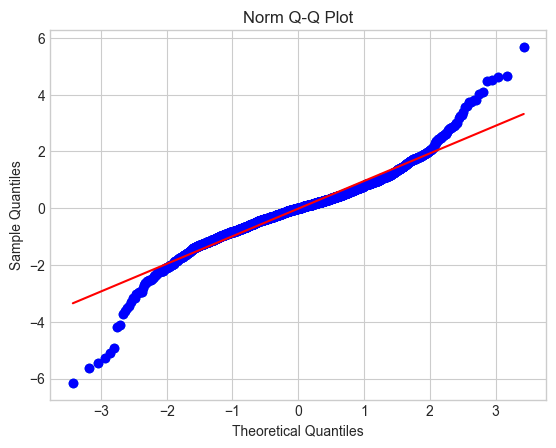

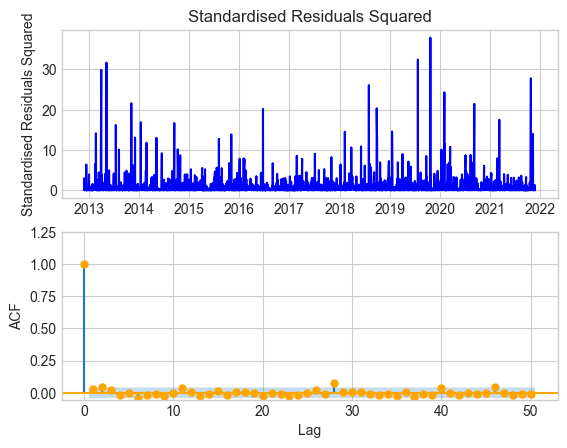

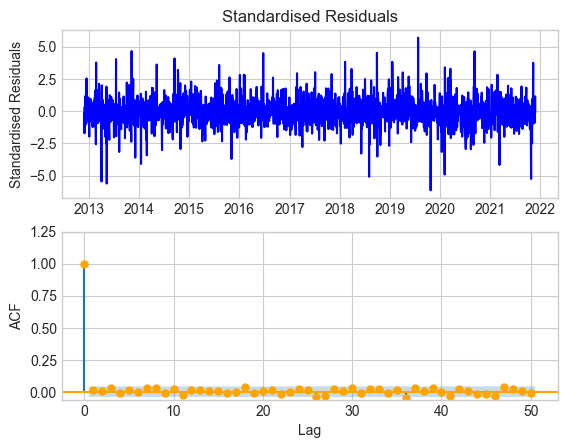

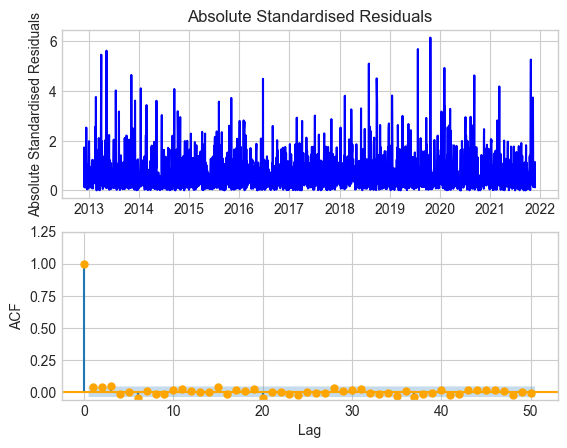

In [4]:

model = arch_model(train_df['loss'],
                    mean='constant', 
                    vol='GARCH', 
                    p=1, q=1, 
                    rescale=True, 
                    dist='normal'
                    )

model_fit_norm = model.fit(update_freq=-1)

plotting.qqplot(model_fit_norm.std_resid, dist='norm')
plt.savefig('../plots/i/i_1.png'); plt.show()

plotting.plot_acf_graphs(model_fit_norm.std_resid**2, 'Standardised Residuals Squared')
plt.savefig('../plots/i/i_2.png'); plt.show()

plotting.plot_acf_graphs(model_fit_norm.std_resid, 'Standardised Residuals')
plt.savefig('../plots/i/i_3.png'); plt.show()

plotting.plot_acf_graphs(np.abs(model_fit_norm.std_resid), 'Absolute Standardised Residuals')
plt.savefig('../plots/i/i_4.png'); plt.show()



# 1ii)

In [5]:

def log_likelihood_function_t(nu, x):
    return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) ) 

objfun_loglikelihood_t = lambda y : -1 * log_likelihood_function_t(y, model_fit_norm.std_resid)

y0 = 2.1

bnds = [(0,np.inf)]

sol_loglikelihood = minimize(objfun_loglikelihood_t, y0 ,method='SLSQP',bounds=bnds, options={'disp': False})

print("Estimate of nu: " + str(sol_loglikelihood.x[0]))
# print("Solution->\n",sol_loglikelihood)

Estimate of nu: 3.8029853217270024


C:\Users\George\AppData\Local\Temp\ipykernel_22572\22632117.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) )
C:\Users\George\AppData\Local\Temp\ipykernel_22572\22632117.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) )


dof=3.8029853217270024


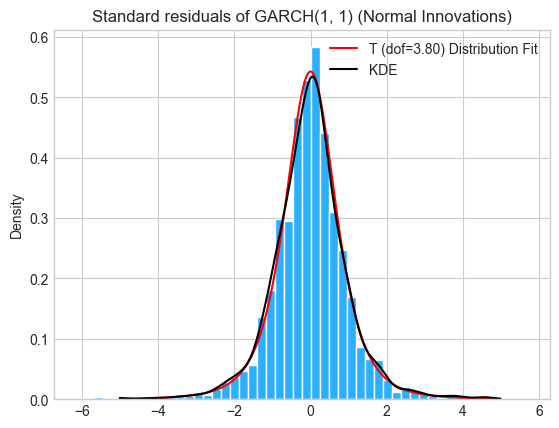

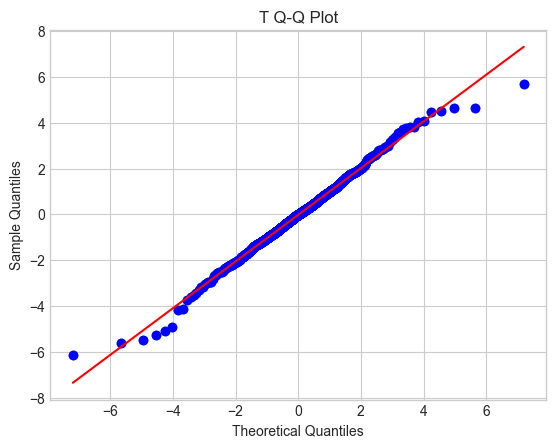

In [6]:
# fit t dist to residuals 
# We force the loc and scale as we are assuming the std residuals ~ SWN(0, 1)


dof=sol_loglikelihood.x[0]
print(f"{dof=}")


t_dist_fit=t(df=dof, loc=0, scale=np.sqrt((dof-2)/dof))


plotting.histogram_w_kde_and_dist(model_fit_norm.std_resid,
            title="Standard residuals of GARCH(1, 1) (Normal Innovations)",
            dist=t_dist_fit,
            dist_name=f'T ({dof=:.2f})')
plt.savefig('../plots/ii/ii_1.png')
plt.show()

plotting.qqplot(model_fit_norm.std_resid, dist=t_dist_fit); 
plt.savefig('../plots/ii/ii_2.png')
plt.show()


# 1iii)


#### Plan
- Create LL function for GPD with parameters $\beta$, $\xi$
- find a reasonable u from the data
- create $Y_{i} (:= X_{i}-u$) from the std_resid

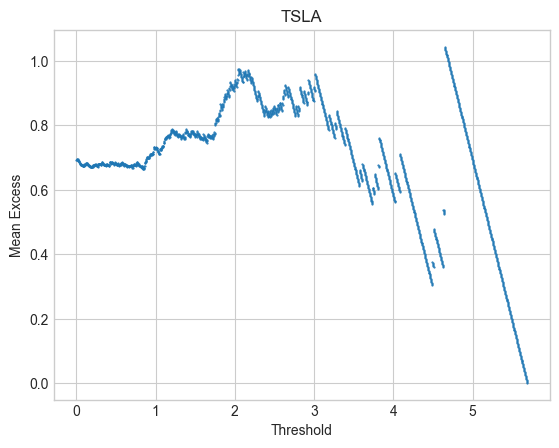

c:\Users\George\projects\masters\qrm2\src\backtesting.py:17: RuntimeWarning: divide by zero encountered in log
  first = -N*np.log(beta)
c:\Users\George\projects\masters\qrm2\src\backtesting.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return first - second


xi=0.0857
beta=0.6697


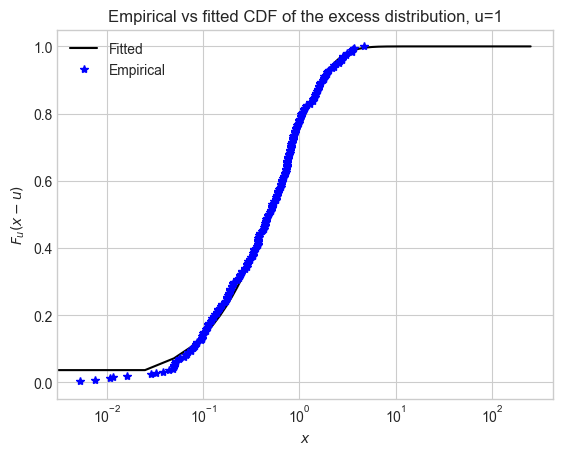

In [7]:

# plot mean excess
x = np.linspace(0, 30, 10001)
mean_excess_y = [bt.mean_excess(model_fit_norm.std_resid, y) for y in x]

ax = plt.scatter(x, mean_excess_y, s=0.3)
plt.xlabel('Threshold')
plt.ylabel('Mean Excess')
plt.title('TSLA');
plt.savefig('../plots/iii/iii_1.png')

plt.show()


# optimise for xi and beta, given u
u = 1
std_resid = model_fit_norm.std_resid
excess_dist = std_resid[std_resid>u] - u

xi, beta = bt.fit_gpd(model_fit_norm.std_resid, u=1)

print(f"{xi=:.4f}")
print(f"{beta=:.4f}")

plotting.plot_excess_dist(y=excess_dist, xi=xi, beta=beta, u=u); 
plt.savefig('../plots/iii/iii_2.png')
plt.show()

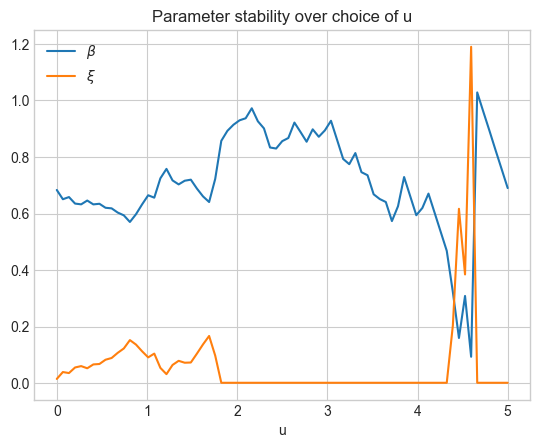

In [8]:
# check the stability of xis over choice of u
us = np.linspace(0, 5, 75)
xis_betas = np.array([bt.fit_gpd(std_resid, u) for u in us])

ax = plt.plot(us, xis_betas[:,1], label=r'$\beta$');
ax = plt.plot(us, xis_betas[:,0], label=r'$\xi$', );
plt.title("Parameter stability over choice of u")
plt.xlabel('u')
plt.legend()
plt.savefig('../plots/iii/iii_3.png')

plt.show()

# 1iv)

### Plan

- compute q values for standard normal (theoretical only)
- compute q values for T dist that we fitted in part ii
- compute q values for gpd that we fitted in iii. For this we need the empirical dist function for u


### Generate std forecasts for test set

In [9]:

# get model fit params
mu, alpha_0, alpha_1, beta_1 = model_fit_norm.params.to_numpy()
print(f"{mu=:.3f} ", f"{alpha_0=:.3f} ", f"{alpha_1=:.3f} ", f"{beta_1=:.3f} ")


# use params to forecast var for both in and out of sample
var = np.zeros_like(df['loss'].dropna())
var[0] = np.var(df['loss'].dropna(), ddof=1) # sample variance

# below is from model_fit_norm.conditional_volatility[0] (using the same starting point as the fitted model)
var[0]=1.833599**2


# Iteration over the GARCH(1,1) dynamics
for i in range(1, len(df['loss'].dropna())):
    var[i] = alpha_0 + alpha_1*(df['loss'].dropna()[i-1] - mu)**2 + (beta_1) * var[i-1]



df['std_forc'] = var**0.5
df['mu'] = mu

# make an alternative one 252 day forecast
model_forecast = model_fit_norm.forecast(horizon=len(test_df))
df.loc[~train_mask,'std_forc_nday'] = (model_forecast.variance.iloc[-1,:]**0.5).to_numpy()
df.loc[train_mask,'std_forc_nday'] = (model_fit_norm.conditional_volatility).to_numpy()



#  std resid using each days std forecast (z_t = (x_t - mu)/std_forc )
df['z_t'] = (df['loss']-df['mu'])/df['std_forc']



mu=-0.151  alpha_0=0.139  alpha_1=0.041  beta_1=0.948 


c:\Users\George\projects\masters\qrm2\venv\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [10]:
alpha = 0.95
q_95_norm = norm().ppf(alpha)
es_95_norm_mult = norm().pdf(q_95_norm)/(1-alpha)

q_95_t = t_dist_fit.ppf(alpha)
es_95_t_mult = t_dist_fit.pdf(q_95_t)*(dof + q_95_t**2)/( (1-alpha)*(dof-1) )

q_95_par = bt.q_alpha_pareto(zs=model_fit_norm.std_resid, alpha=alpha, xi=xi, beta=beta, u=u)
# q_95_par = bt.q_alpha_pareto(zs=excess_dist, alpha=alpha, xi=xi, beta=beta, u=u)

es_95_par_mult = bt.es_pareto_mult(q=q_95_par, beta=beta, xi=xi, u=1)


alpha = 0.99
q_99_norm = norm().ppf(alpha)
es_99_norm_mult = norm().pdf(q_99_norm)/(1-alpha)

q_99_t = t_dist_fit.ppf(alpha)
es_99_t_mult = t_dist_fit.pdf(q_99_t)*(dof+q_99_t**2)/((1-alpha)*(dof-1))


q_99_par = bt.q_alpha_pareto(zs=model_fit_norm.std_resid, alpha=alpha, xi=xi, beta=beta, u=u)
# q_99_par = bt.q_alpha_pareto(zs=excess_dist, alpha=alpha, xi=xi, beta=beta, u=u)

es_99_par_mult = bt.es_pareto_mult(q=q_99_par, beta=beta, xi=xi, u=1)




### Calculate var assuming normal

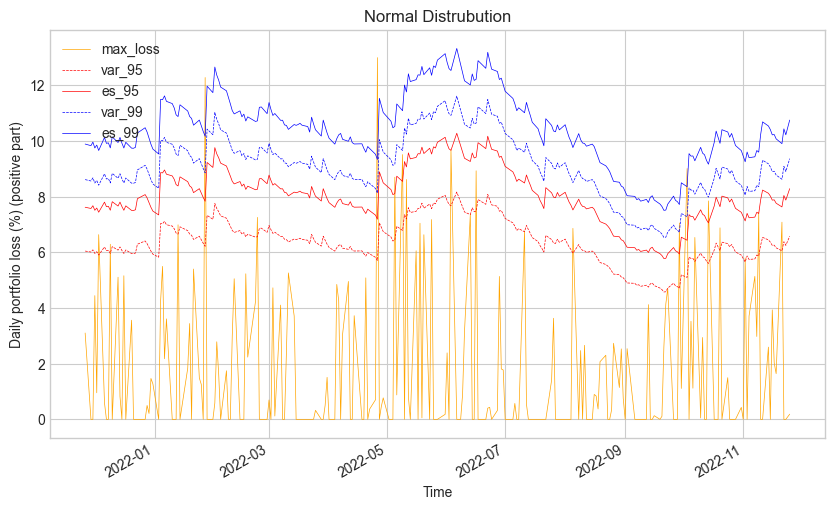

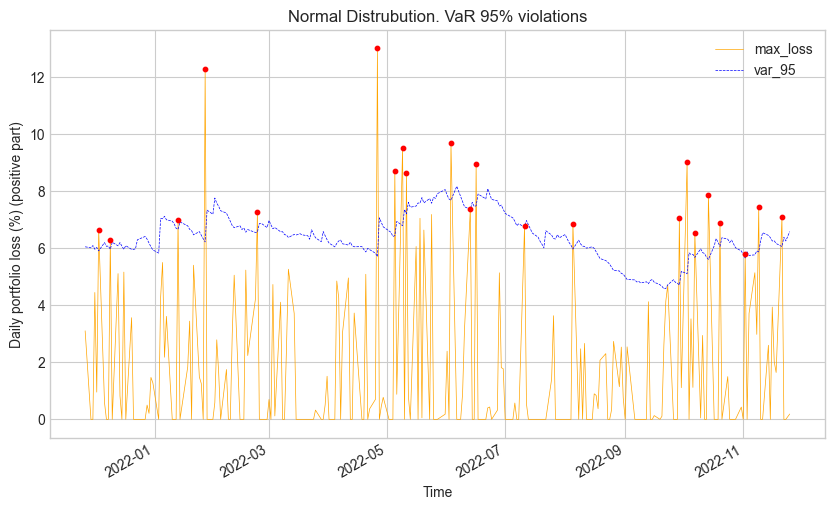

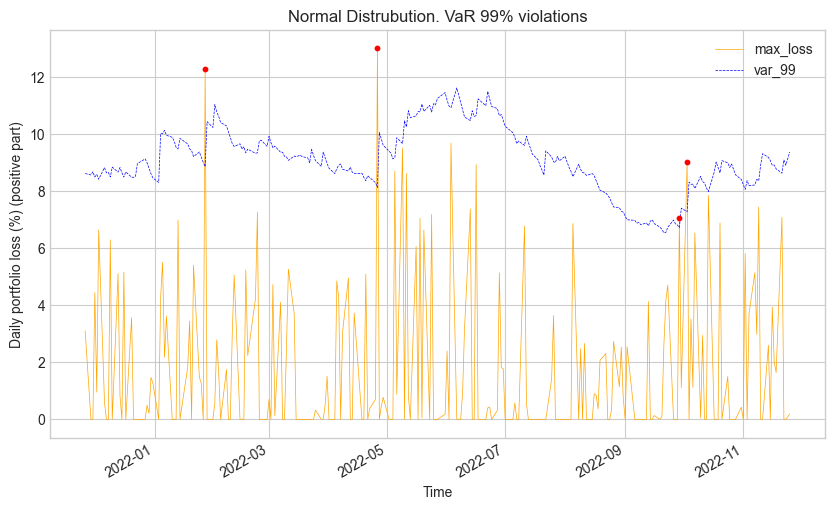

Violations 95%: 22, 8.73%
Violations 99%: 4, 1.59%


In [11]:
df_norm = bt.compute_var_df(df=df[~train_mask], q_95=q_95_norm, q_99=q_99_norm,
                         es_95_mult=es_95_norm_mult, es_99_mult=es_99_norm_mult)
bt.print_viols_and_plot(df_norm, 'Normal Distrubution',1)

### Calculate var assuming t

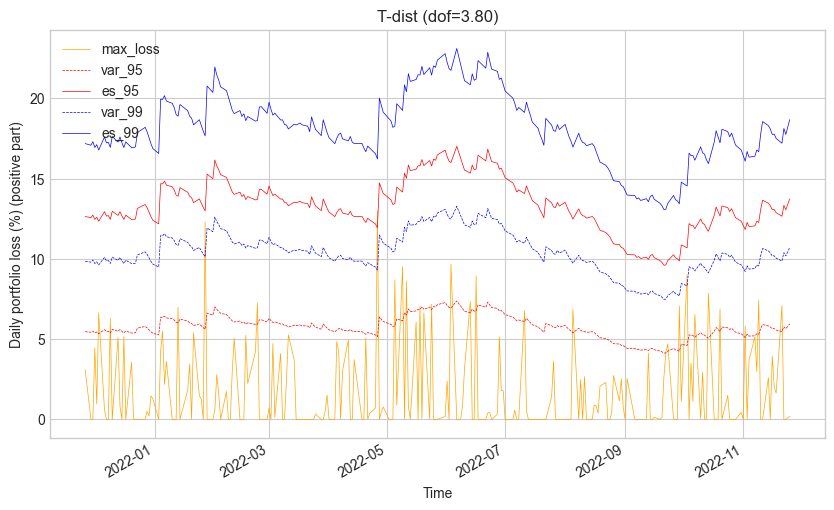

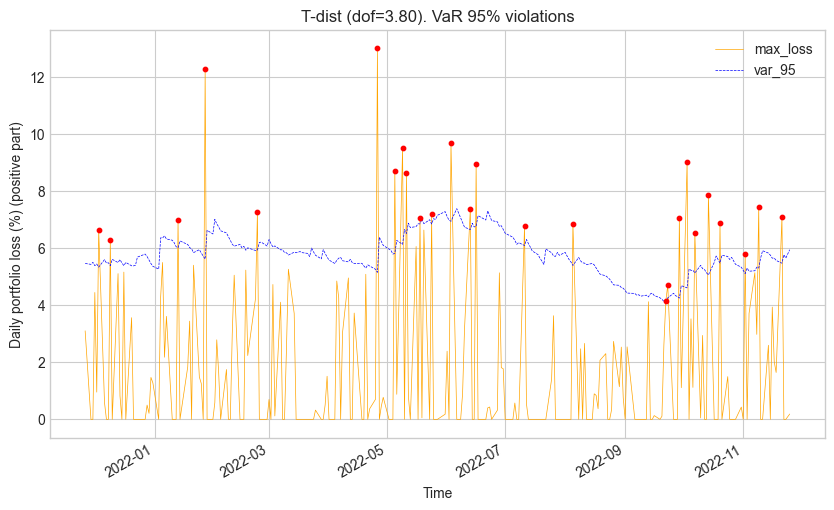

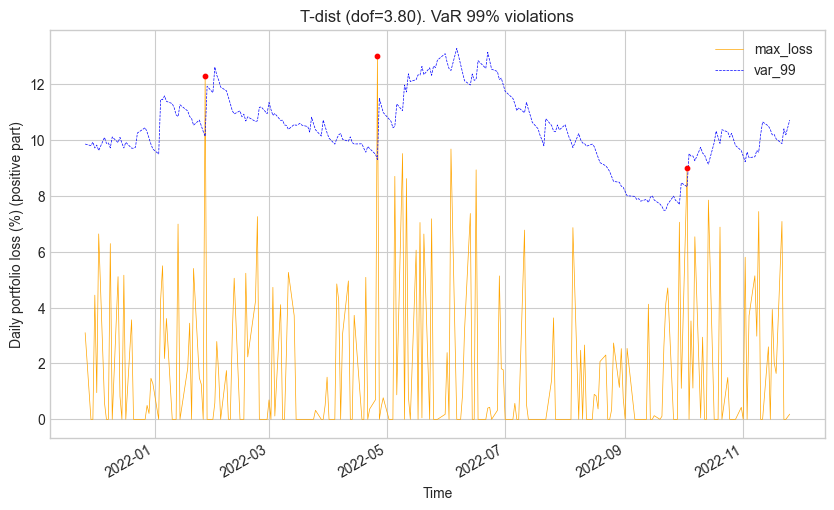

Violations 95%: 26, 10.32%
Violations 99%: 3, 1.19%


In [12]:
df_t = bt.compute_var_df(df=df[~train_mask], q_95=q_95_t, q_99=q_99_t,
                         es_95_mult=es_95_t_mult, es_99_mult=es_99_t_mult)
bt.print_viols_and_plot(df_t, f'T-dist (dof={dof:.2f})',2)

### Calculate var assuming pareto

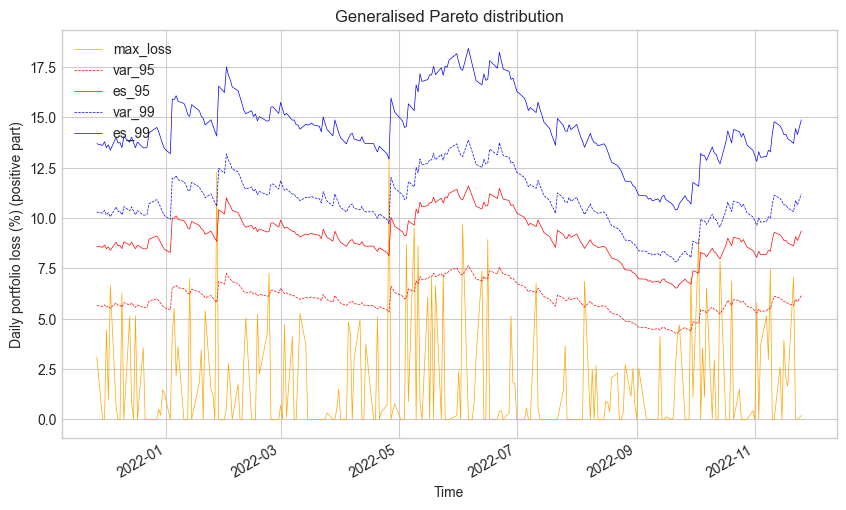

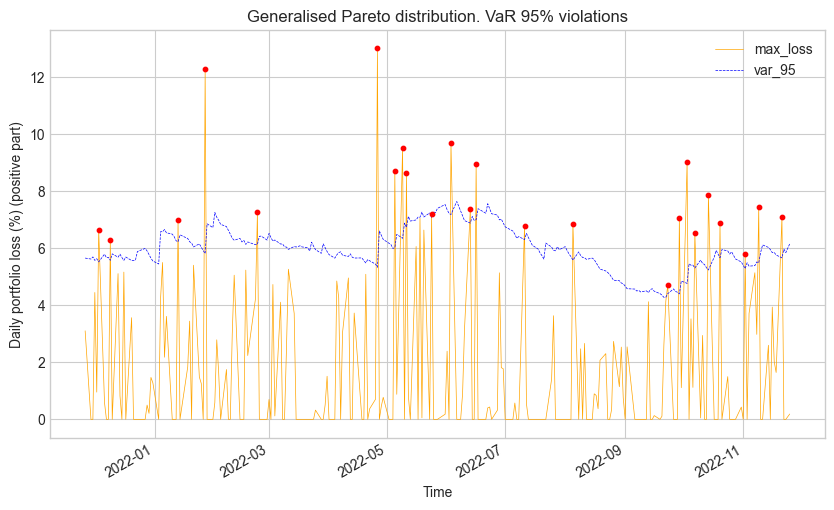

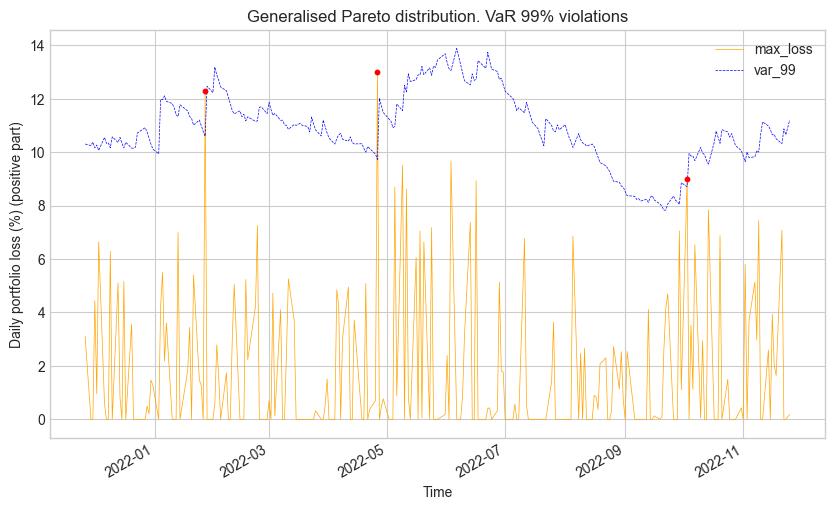

Violations 95%: 24, 9.52%
Violations 99%: 3, 1.19%


In [13]:
df_par = bt.compute_var_df(df=df[~train_mask], q_95=q_95_par, q_99=q_99_par,
                         es_95_mult=es_95_par_mult, es_99_mult=es_99_par_mult)
bt.print_viols_and_plot(df_par, 'Generalised Pareto distribution',3)

In [14]:
backtesting_df = pd.concat(
        [
        bt.get_stats(df_norm, "Normal"),
        bt.get_stats(df_t, "T"),
        bt.get_stats(df_par, "GPD")
        ]).reset_index(drop=True)
backtesting_df

,Title,Alpha,Violations (exp),LR_uc,LR_uc - p
0,Normal,0.95,22 (12.6),6.097,0.01354
1,Normal,0.99,4 (2.5),0.745,0.38804
2,T,0.95,26 (12.6),11.633,0.00065
3,T,0.99,3 (2.5),0.087,0.76797
4,GPD,0.95,24 (12.6),8.681,0.00322
5,GPD,0.99,3 (2.5),0.087,0.76797


## Appendix

#### Explore insample P values


In [15]:

df_norm_train = bt.compute_var_df(df=df[train_mask], q_95=q_95_norm, q_99=q_99_norm,
                         es_95_mult=es_95_norm_mult, es_99_mult=es_99_norm_mult)
df_t_train = bt.compute_var_df(df=df[train_mask], q_95=q_95_t, q_99=q_99_t,
                         es_95_mult=es_95_t_mult, es_99_mult=es_99_t_mult)

df_par_train = bt.compute_var_df(df=df[train_mask], q_95=q_95_par, q_99=q_99_par,
                         es_95_mult=es_95_par_mult, es_99_mult=es_99_par_mult)

backtesting_df_train = pd.concat(
        [
        bt.get_stats(df_norm_train, "Normal"),
        bt.get_stats(df_t_train, "T"),
        bt.get_stats(df_par_train, "GPD")
        ]).reset_index(drop=True)
backtesting_df_train

,Title,Alpha,Violations (exp),LR_uc,LR_uc - p
0,Normal,0.95,104 (113.3),0.825,0.36364
1,Normal,0.99,41 (22.7),12.094,0.00051
2,T,0.95,123 (113.3),0.851,0.35613
3,T,0.99,27 (22.7),0.791,0.37376
4,GPD,0.95,116 (113.3),0.067,0.79542
5,GPD,0.99,25 (22.7),0.236,0.62699


#### Explore alternative (one N day forecast)

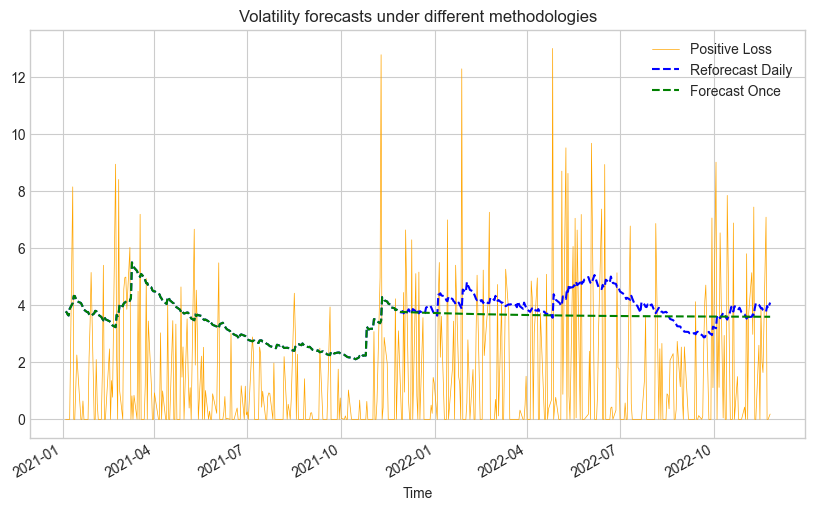

In [16]:
recent_df = df.loc[ '2021-01-01':,:]

ax = recent_df[['max_loss']].plot(c='orange', linewidth=0.5, figsize=(10, 6));
ax = recent_df[['std_forc']].plot(ax=ax, style=['b--'], linewidth=1.5, label='reforecast daily')
ax = recent_df[['std_forc_nday']].plot(ax=ax, style=['g--'], linewidth=1.5, label='reforecast daily')

plt.legend(['Positive Loss','Reforecast Daily', 'Forecast Once'])
ax.set_xlabel("Time"); 
plt.title('Volatility forecasts under different methodologies')

plt.savefig('../plots/appendix/apdx_2.png')

plt.show()



#### Stock price and loss over train/test period 

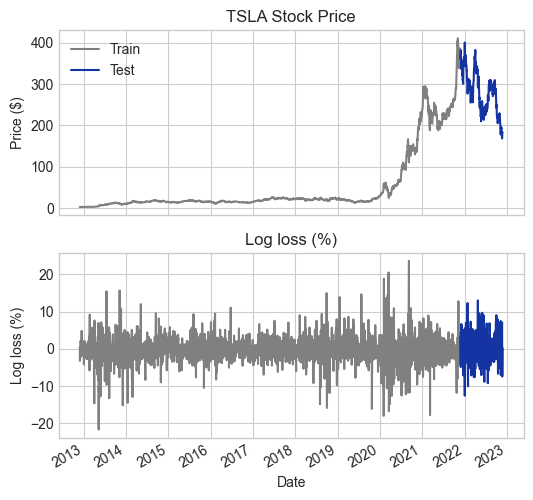

In [17]:
fig, axs = plt.subplots(2,1, figsize=(6,6), sharex=True)
axs[0] = df.loc[train_mask,'TSLA'].plot(logy=False, ax=axs[0], color='#808080')
axs[0] = df.loc[~train_mask,'TSLA'].plot(logy=False, ax=axs[0], color='#1434A4')
axs[0].set_title('TSLA Stock Price')
axs[0].set_ylabel('Price ($)')
axs[0].legend(['Train','Test'])

axs[1] = df.loc[train_mask,'loss'].plot(logy=False, ax=axs[1], color='#808080')
axs[1] = df.loc[~train_mask,'loss'].plot(logy=False, ax=axs[1], color='#1434A4')
axs[1].set_ylabel('Log loss (%)')
axs[1].set_title('Log loss (%)')

plt.legend()
axs[1].get_legend().remove()
plt.savefig('../plots/iv/iv_4.png')
plt.show()